# Preprocessing

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#graph styles
sns.set_style("white", {'ytick.major.size':10})
sns.set_context("poster", font_scale=1.1)

Let's take a look at the user data. The data is contained in two files - a training file and a test file. For now, let's just consider the training file.
Note: I previously loaded this file and noticed that many columns had '-unknown-' as the null value. 
So I'm re-reading in the csv file and replacing these.

In [2]:
#Load the main Airbnb training user file as a dataframe.
train_users = pd.read_csv('./data/train_users_2.csv', na_values='-unknown-')

In [3]:
#preview the data
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
train_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     117763 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              186185 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


#### Initial thoughts

The train_users dataframe is made up of mostly demographics - categorical data that is currently stored as 'objects'. Date fields are currently objects or integers so let's start with converting these to date/time fields. We may also need to somehow extract year/month from the date fieds 

Date_first_booking, age and first_affiliate_tracked have numerous null values. There are some cases where date_first_active is < date_account_created. But Airbnb has explained this in their notes: users can search before signing up.

Otherwise the data seems quite clean, with sensible formats and values.

The target variable for our predictive analysis is 'country_destination'. The column 'date_first_booking' that indicates when this country destination was booked (if no booking was made then 'date_first_booking' is null).

# Cleaning the data

### Convert DATE fields

In [5]:
#convert date data to datetime fields
train_users['date_account_created']=pd.to_datetime(train_users['date_account_created'], format='%Y-%m-%d')
train_users['date_first_booking']=pd.to_datetime(train_users['date_first_booking'])
train_users['timestamp_first_active']=pd.to_datetime(train_users['timestamp_first_active'], format='%Y%m%d%H%M%S')
#train_users.info()

In [6]:
#'timestamp_first_active' is a little misleading now so lets rename it
train_users=train_users.rename(columns={'timestamp_first_active':'date_first_active'})

It will be useful to be able to access just the year and month form the date_account_created column.

In [7]:
date_account_created = pd.DatetimeIndex(train_users['date_account_created'])
date_first_active = pd.DatetimeIndex(train_users['date_first_active'])
#create day, month and year columns for date_account_created and date_first_active
train_users['day_account_created']=date_account_created.day
train_users['month_account_created']=date_account_created.month
train_users['year_account_created']=date_account_created.year
train_users['day_first_active']=date_first_active.day
train_users['month_first_active']=date_first_active.month
train_users['year_first_active']=date_first_active.year

In [8]:
#calc different between users account creation date and the date they were first active
train_users['difference_created_active']=(date_account_created.values - date_first_active.values).astype(int)

In [9]:
train_users.head()

,id,date_account_created,date_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_device_type,first_browser,country_destination,day_account_created,month_account_created,year_account_created,day_first_active,month_first_active,year_first_active,difference_created_active
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,NaN,NaN,facebook,0,en,direct,...,Mac Desktop,Chrome,NDF,28,6,2010,19,3,2009,40246025000000000
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,...,Mac Desktop,Chrome,NDF,25,5,2011,23,5,2009,63180711000000000
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,Windows Desktop,IE,US,28,9,2010,9,6,2009,41042833000000000
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,Mac Desktop,Firefox,other,5,12,2011,31,10,2009,66074311000000000
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,NaN,41.0,basic,0,en,direct,...,Mac Desktop,Chrome,US,14,9,2010,8,12,2009,24169735000000000


### Missing Data

We changed anything marked as '-unknown-' to NaN when we read in the data. But let's see how much data we're missing. 

In [10]:
#compute the % of each field that is missing
missing = (train_users.isnull().sum() / train_users.shape[0]) * 100
missing[missing>0] #only display variables that have data missing

date_first_booking         58.347349
gender                     44.829024
age                        41.222576
first_affiliate_tracked     2.841402
first_browser              12.773892
dtype: float64

From this we can see that we might be concerned about the missing data in 'date_first_booking', 'gender', and 'age'. 

#### Cleaning up Age data

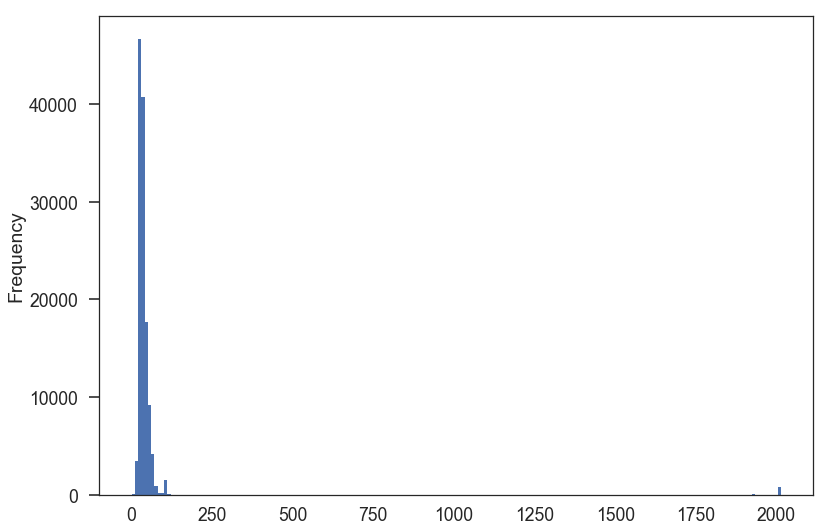

In [11]:
train_users.age.plot(kind='hist', bins=200)
plt.show()

Unless someone has discovered the fountain of youth, it seems likely that we have some problems with our age data.

In [12]:
print("No. of users who listed their age as greater than 100 years: " + str(sum(train_users.age>100)))
print("No. of users who listed their age as greater than 1000 years: " + str(sum(train_users.age>1000)))
print("No. of users who listed their age as greater than 2000 years: " + str(sum(train_users.age>2000)))
print("No. of users who listed their age as greater than 18 years: " + str(sum(train_users.age<18)))
print("No. of users who listed their age as greater than 5 years: " + str(sum(train_users.age<5)))

No. of users who listed their age as greater than 100 years: 2345
No. of users who listed their age as greater than 1000 years: 779
No. of users who listed their age as greater than 2000 years: 750
No. of users who listed their age as greater than 18 years: 158
No. of users who listed their age as greater than 5 years: 12


In [13]:
train_users[train_users.age>100]['age'].describe()

count    2345.000000
mean      738.697655
std       897.655359
min       101.000000
25%       105.000000
50%       105.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [14]:
r = train_users[(train_users['age']>1000) & (train_users['age']<2000)]['age'].sort_values()
print(r)

180995    1924.0
198888    1924.0
114599    1925.0
211496    1926.0
145422    1927.0
81999     1928.0
180961    1928.0
194056    1929.0
189661    1929.0
157181    1931.0
190565    1931.0
55474     1931.0
67610     1932.0
59537     1932.0
67223     1932.0
104695    1933.0
114377    1935.0
102044    1936.0
184424    1936.0
197386    1938.0
160781    1942.0
196558    1947.0
206249    1947.0
208819    1949.0
190142    1949.0
41046     1949.0
118621    1952.0
157318    1953.0
165271    1995.0
Name: age, dtype: float64


These users have probably entered their birth year rather than age.

In [15]:
#for users with age>2000, how many had an age that matched the year their account was created 
age_is_birthyear = train_users[train_users.age == train_users.year_account_created][['age','year_account_created']]
age_is_birthyear.count()


age                     127
year_account_created    127
dtype: int64

Our theory that ages > 2000 might actually be the year the new users account was created does not hold true. There are 750 instances where users have listed their age as older than 2000 years, and of these, only 127 cases where their listed age matches the year that they created their account. 

It looks like a number of users may have written their year of birth as their age (values 1924-1995). There are also a suspicious number of people aged 100 -> 150 and under 18yrs of age (which is the minimum age for booking in Airbnb's terms and conditions). This is most likely people concealing their age for privacy reasons.

For users where age appears to be a birth year (1924-1995) we can calculate their age.  Where age>2000 we should set the age to null. For other strange ages (over 100, less than 18) we really don't have a way to calculate the age from this dataset. We will need to set these values to null if we want our predictive model to take age into account. 

In [16]:
#we can't calculate age for those aged>2000 based on this data so let's reset to null.
users_over_2000 = train_users['age']>2000
train_users.loc[users_over_2000, 'age']=np.nan

In [17]:
#let's deal with the cases where age is probably the year of birth by converting their data to their age.
users_with_year_age = train_users['age']>1000 
#calc age (approximate as we're using 2014, not year account created)
train_users.loc[users_with_year_age, 'age'] = 2014 - train_users.loc[users_with_year_age,'age'] 

Now let's deal with users where age is over 100 or less than 18.   
We can't reasonably assume their age so we will reset to null.
For this exercise I've chosen 18 and 100 to be the age cutoffs. 18 was used as this is the minimum age set by Airbnb's 
terms and conditions. 100 - this is quite arbritrary. The instances of people over the age of 100 travelling, booking their own accommodation and not staying in a family home are very small.

In [18]:
train_users.loc[(train_users['age']>100) | (train_users['age']<18),'age'] = np.nan 
train_users['age'].describe()

count    122987.000000
mean         36.585013
std          11.697972
min          18.000000
25%          28.000000
50%          34.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64

That looks a little more reasonable! But how has this affected our null data percentage?

In [19]:
#Missing data - after cleaning up age what does it look like
missing = (train_users.isnull().sum() / train_users.shape[0]) * 100
missing[missing>0] #only display variables that have data missing

date_first_booking         58.347349
gender                     44.829024
age                        42.381624
first_affiliate_tracked     2.841402
first_browser              12.773892
dtype: float64

In the original dataset, 41.2% of the age data was missing. After cleaning the data, 42.4% is now missing. That's a lot of missing data. We could impute the age data, but let's wait until we work out if there is a difference between those who enter age vs those who don't enter their age. 

#### Convert Categorical Fields

In [33]:
#Commenting this step out for now as I'm having problems with later analysis that might stem from this


#category_fields = [
 #   'country_destination', 'first_browser', 'first_device_type','signup_app', 'first_affiliate_tracked', 'affiliate_provider', 'affiliate_channel', 'language', 'signup_method', 'gender']
#for category_field in category_fields:
 #   train_users[category_field] = train_users[category_field].astype('category')
#train_users.info()    

In [20]:
#It might be useful to have an indicator to differentiate users who booked against those who didn't. 
train_users['booked']=(train_users['country_destination'] != 'NDF').astype(int)


In [22]:
#It also might be userful to have a flag for those that didn't provide their age (or provided a clearly inaccurate age) 
train_users['age_is_missing']=(train_users['age'] >0 ).astype(int)

#let's also add a flag for gender
#train_users['gender_is_missing']=(train_users['gender'] is not None).astype(int)

train_users.head()

,id,date_account_created,date_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,country_destination,day_account_created,month_account_created,year_account_created,day_first_active,month_first_active,year_first_active,difference_created_active,booked,age_is_missing
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,NaN,NaN,facebook,0,en,direct,...,NDF,28,6,2010,19,3,2009,40246025000000000,0,0
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,...,NDF,25,5,2011,23,5,2009,63180711000000000,0,1
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,US,28,9,2010,9,6,2009,41042833000000000,1,1
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,other,5,12,2011,31,10,2009,66074311000000000,1,1
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,NaN,41.0,basic,0,en,direct,...,US,14,9,2010,8,12,2009,24169735000000000,1,1


# Data Exploration

### Country destination

In [23]:
#Let's take a look at the country destination values, as they will be a key part of our analysis
country_year = train_users[['id','country_destination','date_first_booking', 'date_account_created', 'year_account_created']]
countries = country_year.groupby(['country_destination']).size()
df_countries=pd.DataFrame(countries)
df_countries.columns = ['count']
df_countries

,count
country_destination,
AU,539
CA,1428
DE,1061
ES,2249
FR,5023
GB,2324
IT,2835
NDF,124543
NL,762


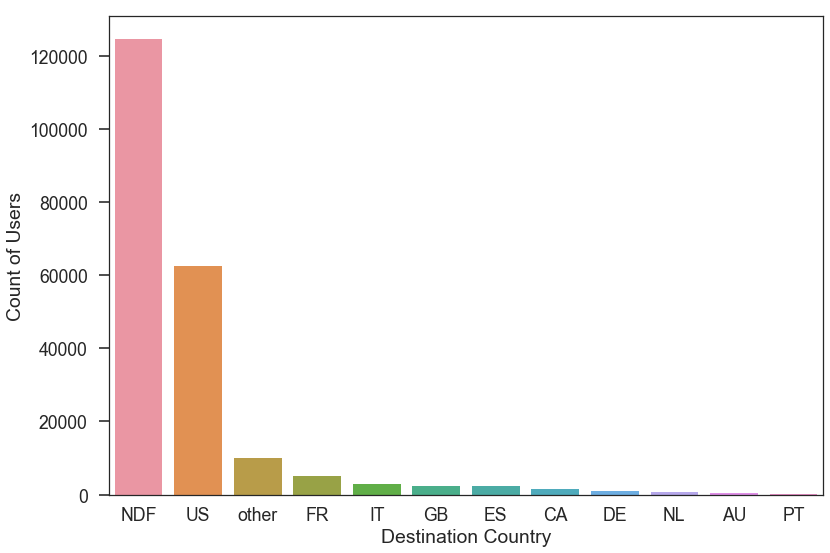

In [24]:
sns.countplot(x='country_destination', data=train_users, order=list(train_users.country_destination.value_counts().keys()) )
plt.xlabel('Destination Country')
plt.ylabel('Count of Users')
#sns.color_palette("muted", 12)
sns.despine
plt.show()

Looking at the country breakdown we can see that almost all users fall into 2 categories - US or NDF (yet to make a booking). If a booking occurs, it is likely to occur in the US. However, 45% of new users do not make a reservation. 

Does taking year of first booking into account have any affect on this pattern? What about age?

#### Gender


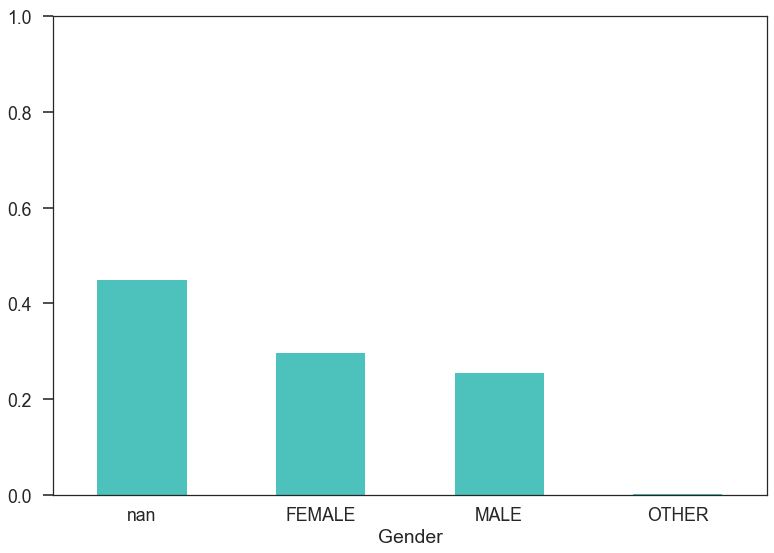

In [25]:
#Graph gender, keep NaNs since we want to see how many nulls we have)
train_users.gender.value_counts(dropna=False, normalize=True).plot(kind='bar', color='lightseagreen', alpha=0.8, rot=0)
plt.xlabel('Gender')
plt.ylim(0,1)
plt.show()

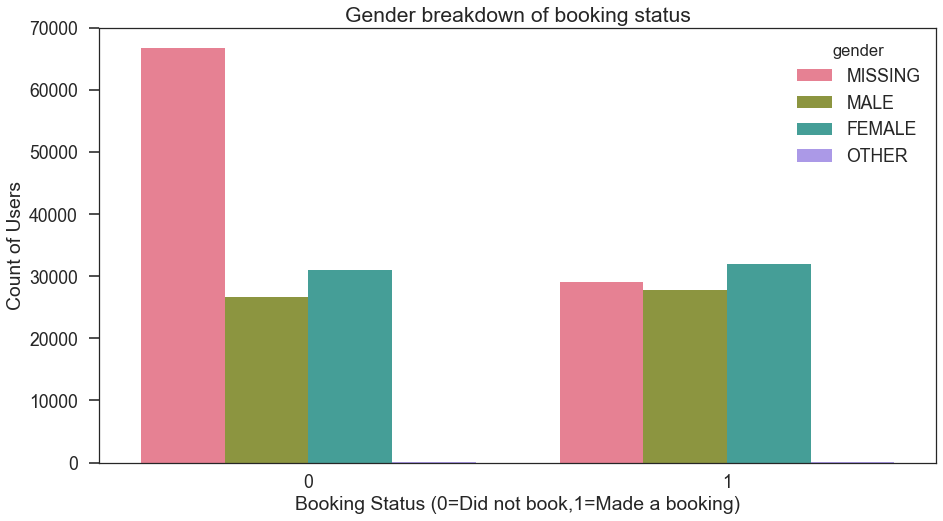

In [35]:
fig = plt.subplots(1,1,sharex=True,figsize=(15,8))
sns.countplot(x='booked', hue='gender', data=train_users.fillna('MISSING'), palette='husl')
plt.title('Gender breakdown of booking status')
plt.xlabel('Booking Status (0=Did not book,1=Made a booking)')
plt.ylabel('Count of Users')
plt.show()

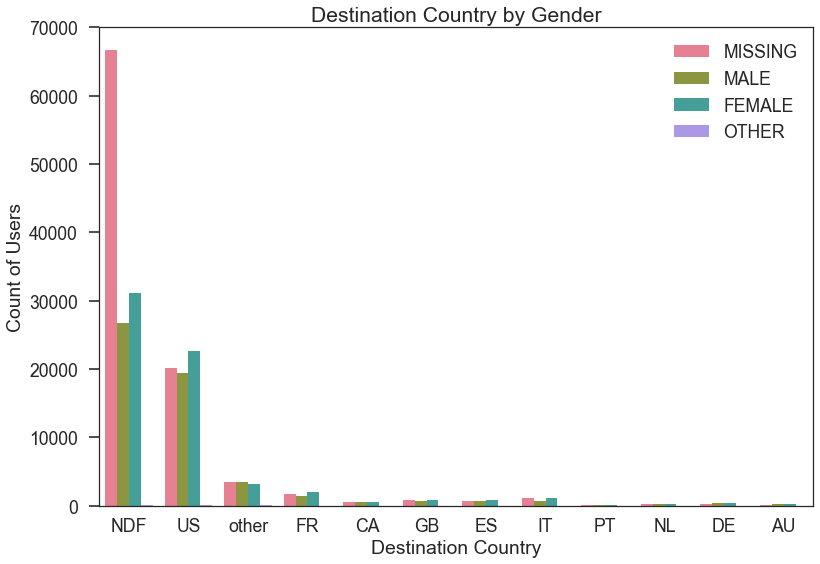

In [28]:
sns.countplot(x='country_destination', data=train_users.fillna('MISSING'), hue='gender', palette='husl')
plt.legend()
plt.title('Destination Country by Gender')
plt.xlabel('Destination Country')
plt.ylabel('Count of Users')
plt.show()

45% of users did not provide their gender. Those who did not provide gender are less likely to book. 

Of those that provided gender, more females than males use Airbnb and females are slightly more likely to book than makes. The overall distribution of gender is not the same for each country so gender might be userful in our predictions. 

#### Dates

In [36]:
#let's see if this breakdown holds true across all years.
#table of country_destination by year
table = pd.crosstab(index=country_year['year_account_created'],columns=country_year['country_destination'], dropna=False)#, normalize='index')
table


country_destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
year_account_created,,,,,,,,,,,,
2010,7,42,16,43,120,28,30,1185,11,1,1228,77
2011,38,125,96,197,469,173,199,5342,68,24,4486,558
2012,103,291,290,470,1121,517,576,21713,148,33,12285,1915
2013,239,520,404,825,1852,865,1036,49076,284,76,23938,3845
2014,152,450,255,714,1461,741,994,47227,251,83,20439,3699


In [37]:
#table of country_destination by year, with % across the rows
#table2 =  pd.crosstab(index=country_year['year_account_created'],columns=country_year['country_destination'], dropna=False, normalize='index')
#table2.plot(colormap='Set1').legend(loc='center left', bbox_to_anchor=(1,0.5))

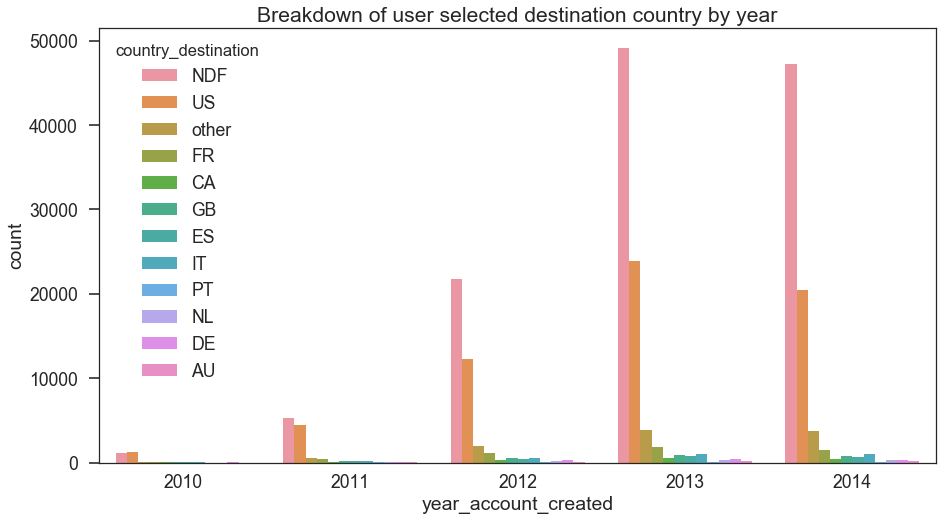

In [38]:
fig = plt.subplots(1,1, sharex=True, figsize=(15,8))
sns.countplot(x='year_account_created',hue='country_destination',data=train_users)
#sns.countplot(x='year_account_created',hue='country_destination',data=train_users[train_users['country_destination'] != 'NDF'])

plt.title('Breakdown of user selected destination country by year')
plt.show()

Across all years, US and NDF was the most common first destination for the US based sample. 
The proportions have changed over time, however the biggest change is in the total number of users. 
Our test user file only contains users from July 2014 ->, so it may be worth focusing on the more recent data when we develop our prediction model.


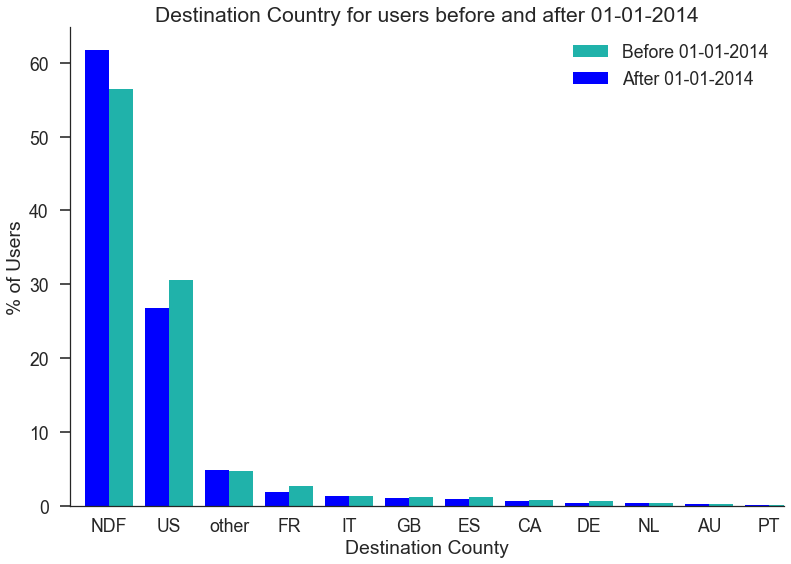

In [39]:
date_2014 = pd.to_datetime(20140101, format='%Y%m%d')

before_2014 = sum(train_users.loc[train_users['date_account_created'] < date_2014,'country_destination'].value_counts())
after_2014 = sum(train_users.loc[train_users['date_account_created'] > date_2014,'country_destination'].value_counts())
#calc %, country_destination before 01-01-2014 and after 01-01-2014
before_2014_dest = train_users.loc[train_users['date_account_created'] < date_2014,'country_destination'].value_counts() / before_2014 * 100
after_2014_dest = train_users.loc[train_users['date_account_created'] > date_2014,'country_destination'].value_counts() / after_2014 * 100

#plot
before_2014_dest.plot(kind='bar', width=0.4, color='lightseagreen', position=0, label = 'Before 01-01-2014', rot=0)
after_2014_dest.plot(kind='bar', width=0.4, color='blue', position=1, label = 'After 01-01-2014', rot=0)
plt.legend()
plt.xlabel('Destination County')
plt.ylabel('% of Users')
plt.title('Destination Country for users before and after 01-01-2014')
sns.despine()
plt.show()

From this we can see that a higher percentage of new users in the post-20140101 data don't make an initial booking, as compared to the pre-20140101 users. The post-20140101 users who do make a booking are even more likely to make a booking within the US. Bookings for France are also slightly higher in the post-20140101 data. 

#### Language of user

In [40]:
ESL = sum(train_users.language != 'en')/ train_users.shape[0] *100
print("Percentage of users  with an international language prefernce other than english: " + str(ESL))

Percentage of users  with an international language prefernce other than english: 3.34362453209


Only 3.3% of users in this dataset had their language preferences set to something other than english. 

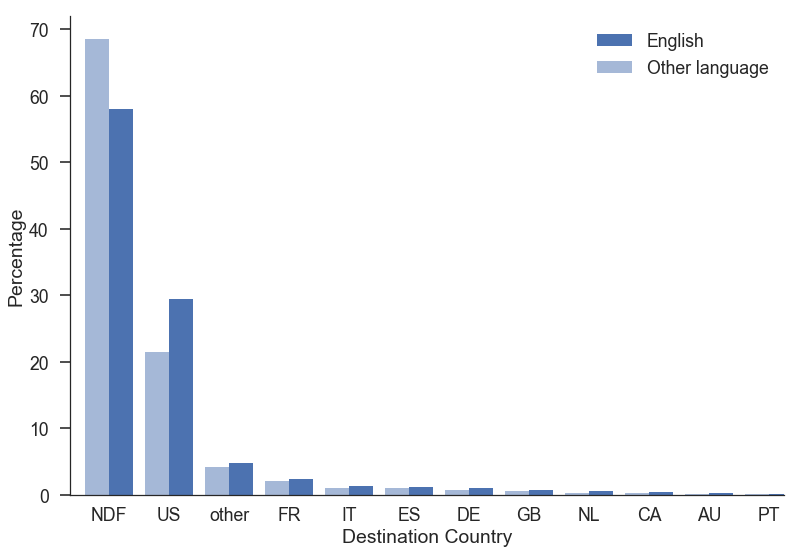

In [41]:
en = sum(train_users.loc[train_users['language']=='en', 'country_destination'].value_counts())
other = sum(train_users.loc[train_users['language'] !='en', 'country_destination'].value_counts())

en_destinations = train_users.loc[train_users['language']== 'en', 'country_destination'].value_counts()/en * 100
other_destinations = train_users.loc[train_users['language']!= 'en', 'country_destination'].value_counts()/other * 100

en_destinations.plot(kind='bar', width=0.4, position=0, label='English', rot=0)
other_destinations.plot(kind='bar', width=0.4, alpha=0.5, position=1, label='Other language', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

Language doesn't seem to play a huge role in predicting the destination country. Users with their preferences set to a language other than english are more likely to book, with most of those that are booking still choosing to book in the US (although we see slight increases in bookings to all destinations). 

#### Age

The biggest problem that we have with any analysis of age is the quality of the data. Even after cleaning, 42% is still unknown and we've seen that there are self reporting issues so the accuracy of those ages that we have are questionable. But let's take a look at what we have. 

In [42]:
train_users.age.describe()

count    122987.000000
mean         36.585013
std          11.697972
min          18.000000
25%          28.000000
50%          34.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64

/Users/tracyburns/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


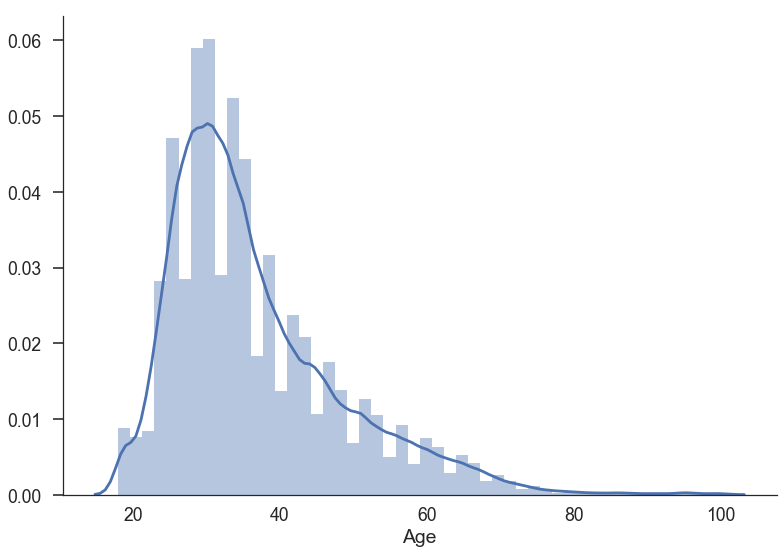

In [43]:
sns.distplot(train_users.age.dropna())
plt.xlabel('Age')
sns.despine()
plt.show()

Most new users on Airbnb are aged between 28 and 42, with a peak between 30-35 .



/Users/tracyburns/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


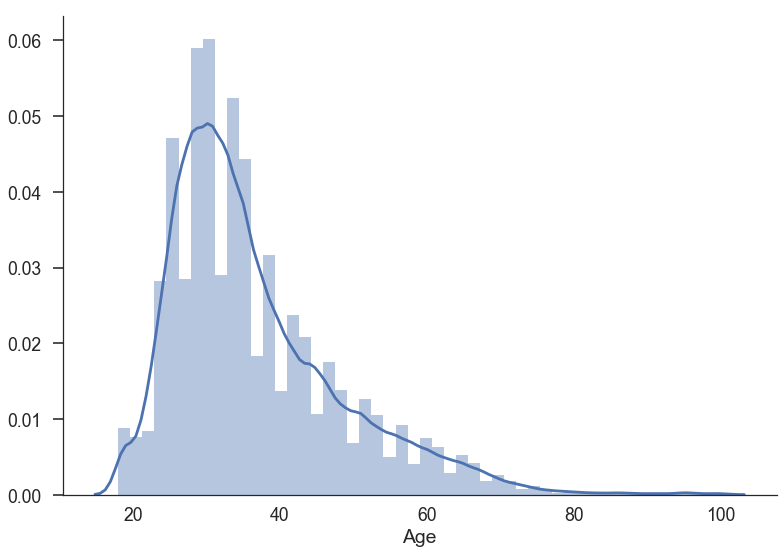

In [45]:
sns.distplot(train_users.age.dropna())
plt.xlabel('Age')
sns.despine()
plt.show()

If we exclude those users who did not make a booking, the age distribution is very similar. 

Is there a difference in destination choice based on age? For instance, we have quite a long tail of older travellers - do they make different destination choices? 


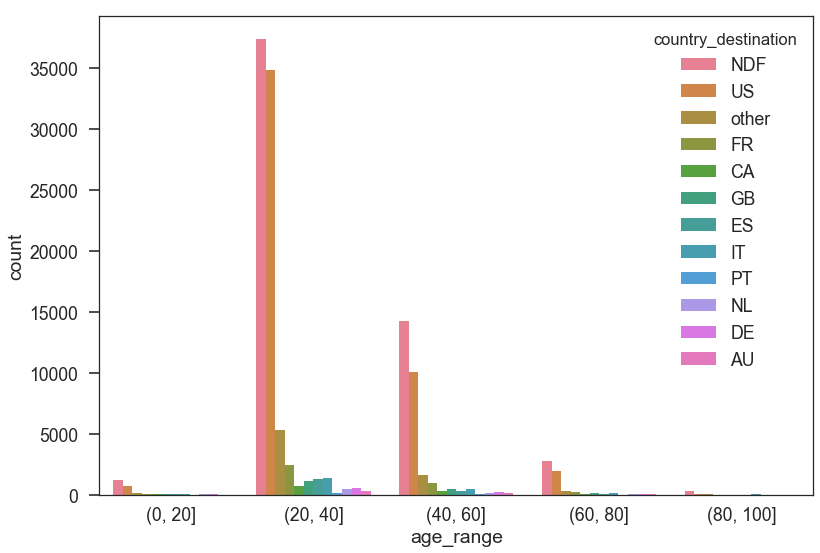

In [46]:
#cut age values into ranges
train_users['age_range'] = pd.cut(train_users['age'],[0,20,40,60,80,100])
#train_users.head()
fig = plt.subplots(1,1)
sns.countplot(x='age_range',hue='country_destination',data=train_users, palette='husl')
plt.show()

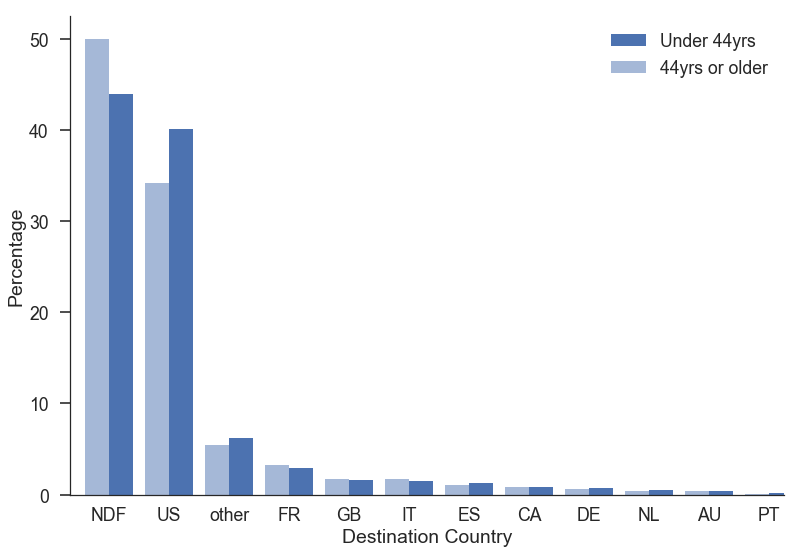

In [47]:
#looking at it another way
age = 44
under_44 = sum(train_users.loc[train_users['age']<age, 'country_destination'].value_counts())
over = sum(train_users.loc[train_users['age']>=age, 'country_destination'].value_counts())

under_44_destinations = train_users.loc[train_users['age']<age, 'country_destination'].value_counts()/under_44 * 100
over_destinations = train_users.loc[train_users['age']>=age, 'country_destination'].value_counts()/over * 100

under_44_destinations.plot(kind='bar', width=0.4, position=0, label='Under 44yrs', rot=0)
over_destinations.plot(kind='bar', width=0.4, alpha=0.5, position=1, label='44yrs or older', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()


From this we can see that those aged 44yrs or older are less likely to make a booking than those aged under 44yrs, but those that book are slightly more likely to travel overseas than their younger counterparts. There are some slight differents in destination choices.  

However there isn't a huge difference between the two groups, and as we are missing 42% of age data it's probably time to move onto looking at other factors.  

#### Age -  Missing data
Is there a difference between users who had missing data? 

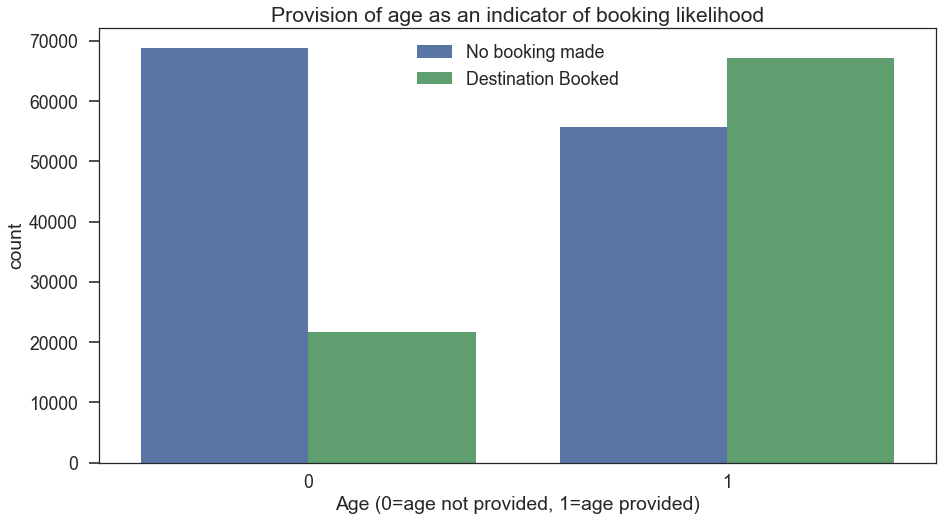

In [48]:
fig = plt.subplots(1,1,sharex=True,figsize=(15,8))
sns.countplot(x='age_is_missing', hue='booked', data=train_users)
plt.legend(['No booking made','Destination Booked'])
plt.xlabel('Age (0=age not provided, 1=age provided)')
plt.title('Provision of age as an indicator of booking likelihood')
plt.show()

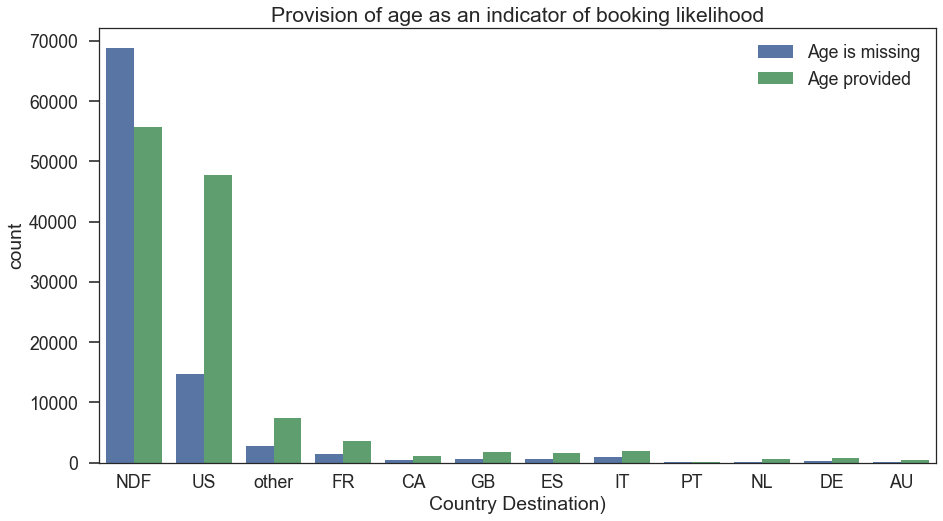

In [49]:
fig = plt.subplots(1,1,sharex=True,figsize=(15,8))
sns.countplot(x='country_destination', hue='age_is_missing', data=train_users)
plt.legend(['Age is missing','Age provided'])
plt.xlabel('Country Destination)')
plt.title('Provision of age as an indicator of booking likelihood')
plt.show()

We can clearly see that users who provide a valid age are more likely to make a booking. Users who don't provide an age re less likely to book a US based holiday.  And we've already seen that those who don't provide gender are less likely to book. 

#### Dates

Is there any variation:
1) By year?
2) By time of year? 
3) By days of the week? 

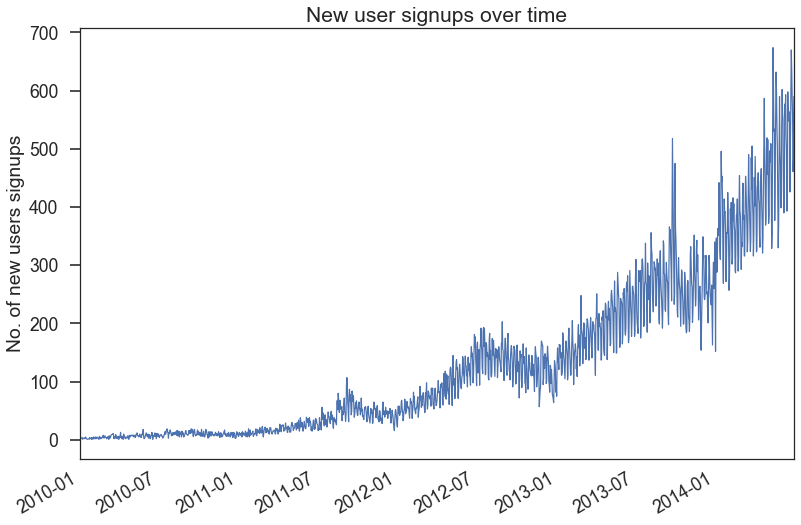

In [75]:
train_users.date_account_created.value_counts().plot(kind='line', linewidth=1.2)
plt.ylabel('No. of new users signups')
plt.title('New user signups over time')
plt.show()

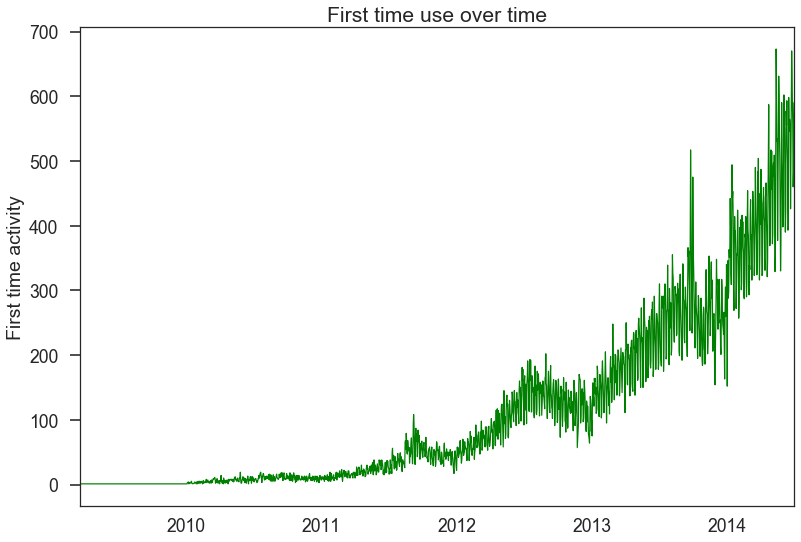

In [51]:
#Is the pattern the same for 'date_first_active'? The time component of the date/time field is making the
#graph display as a flat line so let's drop it
train_users['new_active_date'] = train_users['date_first_active'].apply(lambda x: x.date())
train_users.head()

train_users.new_active_date.value_counts().plot(kind='line', linewidth=1.2, color='green')
plt.ylabel('First time activity')
plt.title('First time use over time')
plt.show()


The growth in new user signups between 2012-2014 is quite amazing. The growth and pattern of the two graphs is quite similar. There appears to be some seasonality to the bookings - bookings increase in the US summer months, and peak around September (labour day?), before declining towards year end. Of course this pattern may only apply to US or northern hemisphere countries. 

#### Signup app

SyntaxError: invalid syntax (<ipython-input-53-e2d6f2861718>, line 2)

### Affiliate Information

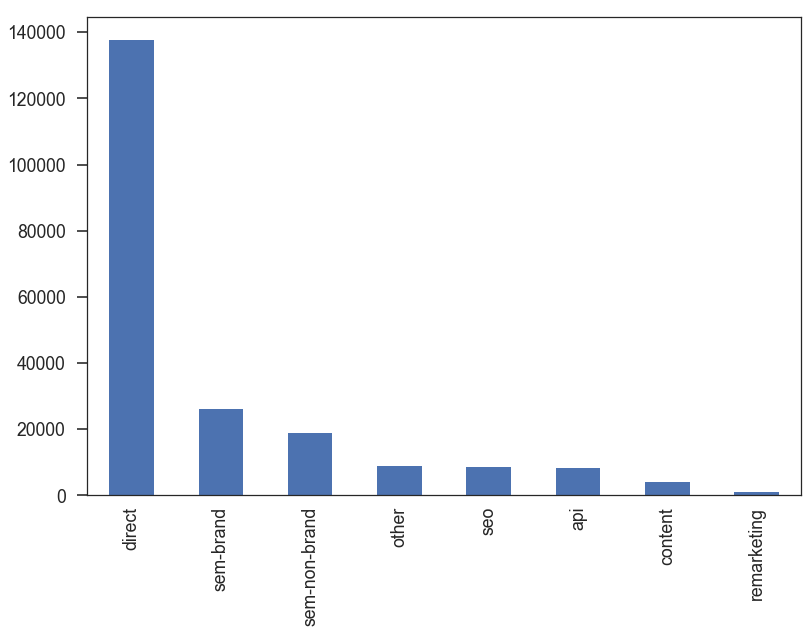

In [58]:
train_users.affiliate_channel.value_counts().plot(kind='bar')
plt.show()

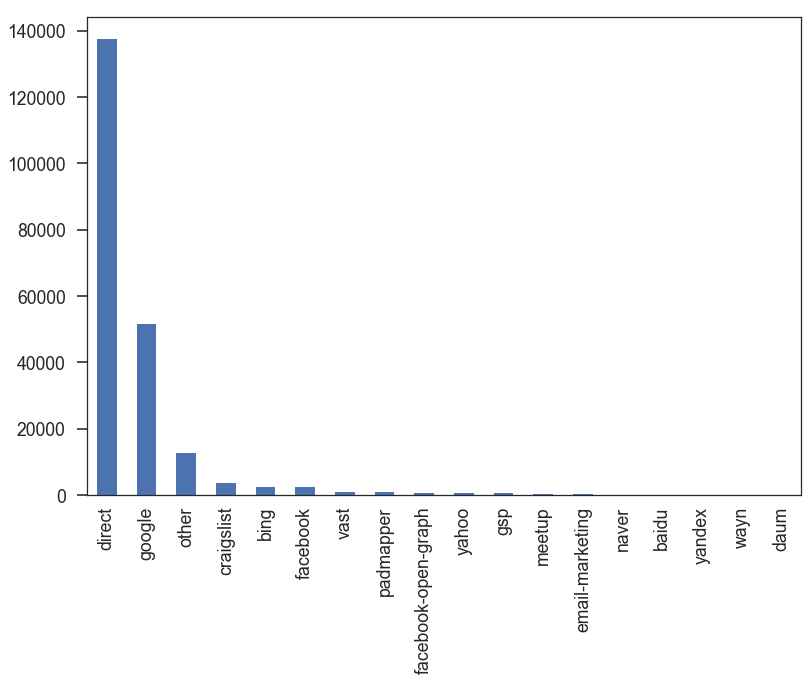

In [59]:
train_users.affiliate_provider.value_counts().plot(kind='bar')
plt.show()

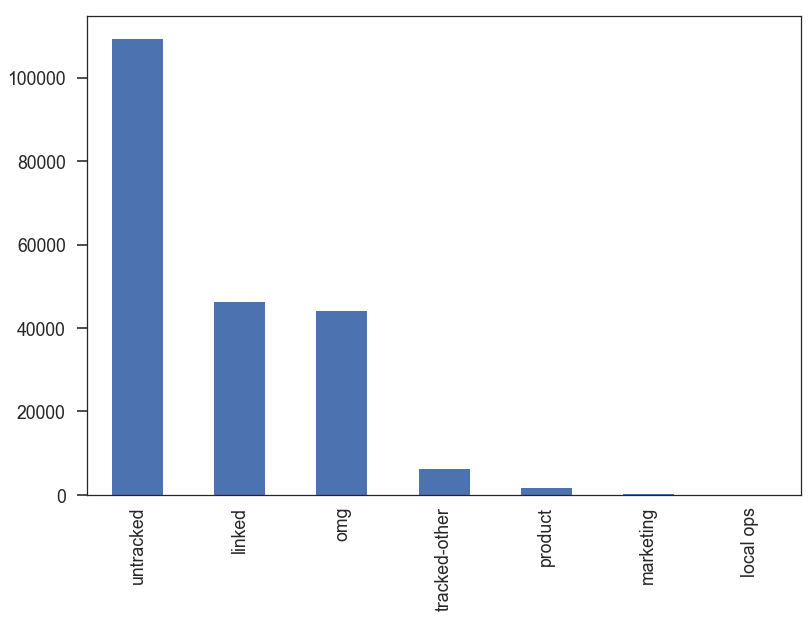

In [63]:
train_users.first_affiliate_tracked.value_counts().plot(kind='bar')
plt.show()

### Signup Info

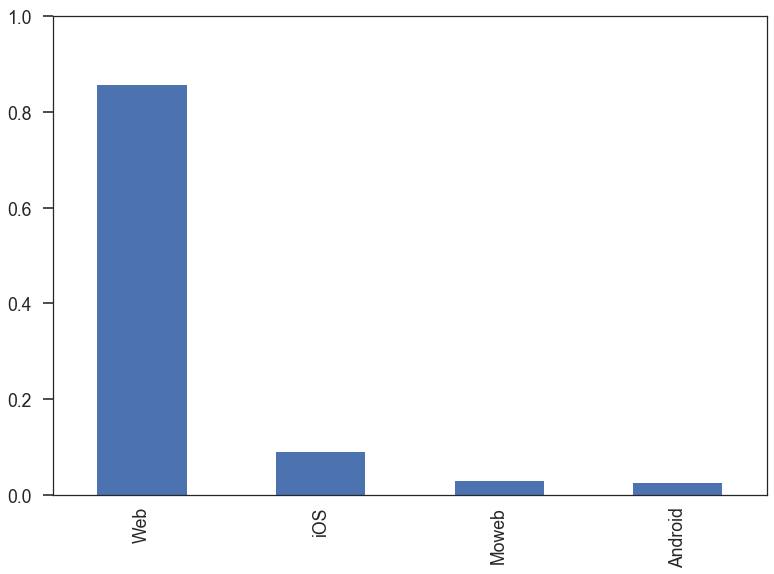

In [72]:
train_users.signup_app.value_counts(normalize=True).plot(kind='bar')
plt.ylim(0,1)
plt.show()

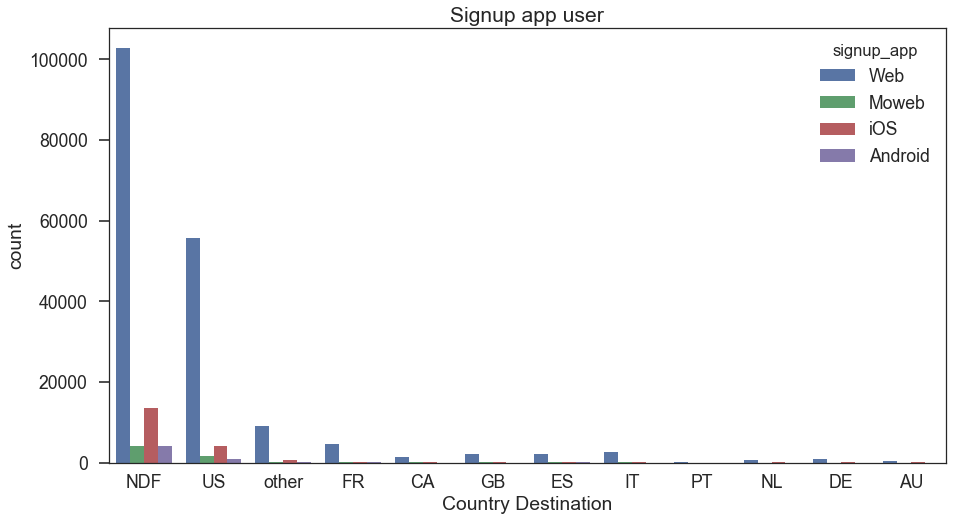

In [69]:
fig = plt.subplots(1,1,sharex=True,figsize=(15,8))
sns.countplot(x='country_destination', hue='signup_app', data=train_users)
plt.xlabel('Country Destination')
plt.title('Signup app user')
plt.show()

Over 80% of users signup using a web browser

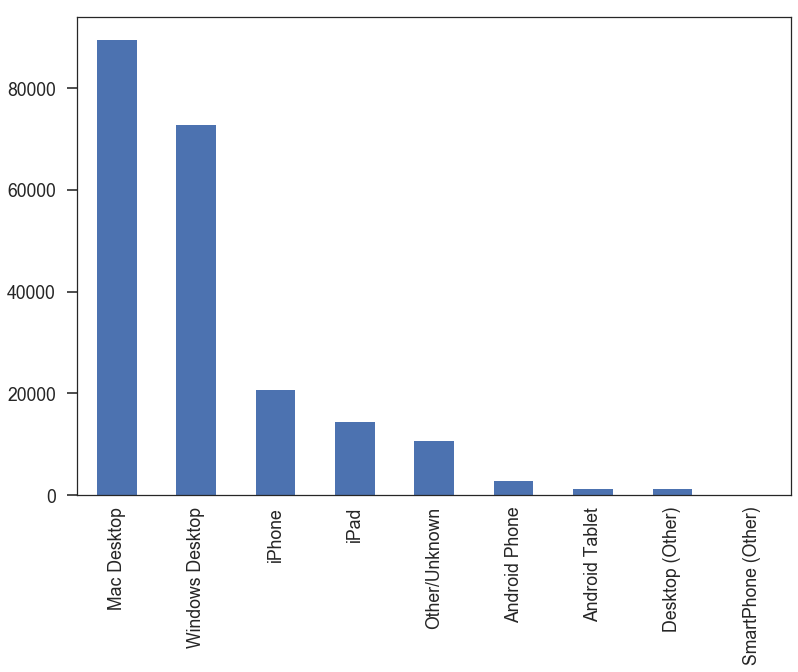

In [66]:
train_users.first_device_type.value_counts().plot(kind='bar')
plt.show()

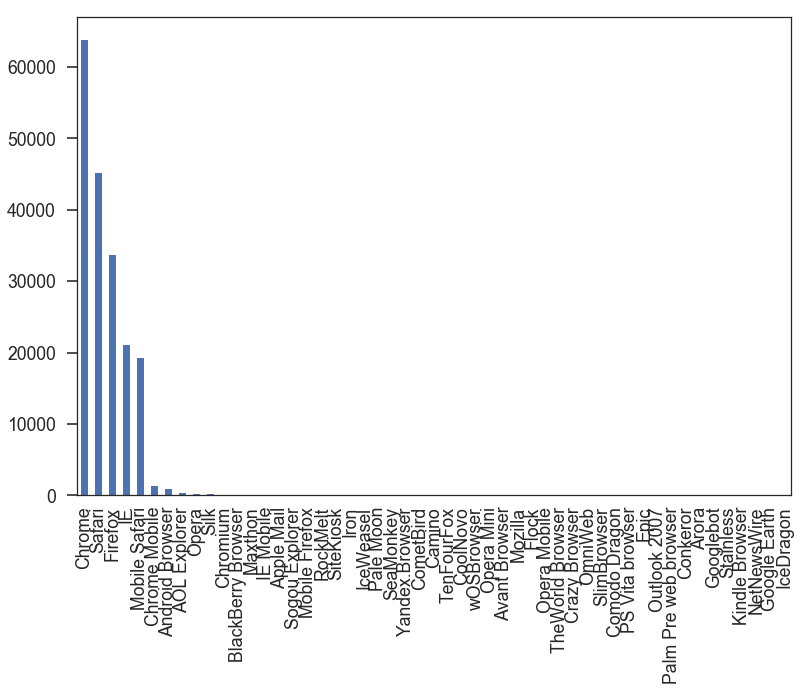

In [67]:
train_users.first_browser.value_counts().plot(kind='bar')
plt.show()

In [62]:
train_users.columns

Index(['id', 'date_account_created', 'date_first_active', 'date_first_booking',
       'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'day_account_created', 'month_account_created',
       'year_account_created', 'day_first_active', 'month_first_active',
       'year_first_active', 'difference_created_active', 'booked',
       'age_is_missing', 'age_range', 'new_active_date'],
      dtype='object')

# Sessions Data

In [73]:
#Load the Airbnb training user file as a dataframe.
sessions = pd.read_csv('./data/sessions.csv')
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
